In [2]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

# $v_\text{1kpc}$ vs. $v_\text{max}$

First, imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os

import dataset
import curve_fit

import importlib

In [2]:
importlib.reload(dataset)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/ad/lxhome/k/kassiili/Linux/SummerProject/APOSTLE_data_analysis/curve_fit.py'>

## Get data

Next, I retrieve the data. We are only interested in luminous halos. Also, there might be some spurious cases with odd values of $v_\text{max}$.

In [3]:
# Get LCDM data:
LCDM = dataset.Dataset("V1_MR_fix_127_z000p000", "LCDM_MR")
vmax = LCDM.get_subhalos("Vmax",False)[0]
v1kpc = LCDM.get_subhalos("V1kpc",False)[0]

# Convert to proper units:
vmax = vmax / 100000 # cm/s to km/s

[  0 514 472 229  41  56  58  25  25  17  16  17  29  23  14  17  20  10
  14   4]


IndexError: list index out of range

## Plot

ValueError: x and y must be the same size

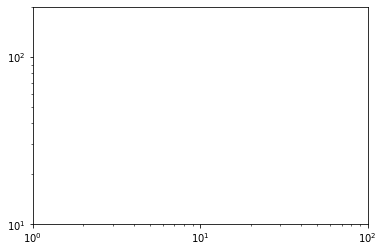

In [4]:
fig, axes = plt.subplots()

# Set axis:
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(1, 100)
axes.set_ylim(10, 200)

# Set marker styles:
color = {LCDM.name : "pink"}
marker = {LCDM.name : (3,0,0)}

# Add LCDM scatter plot:
axes.scatter(v1kpc,vmax, marker=marker[LCDM.name], c=color[LCDM.name], \
        edgecolor='none', label=LCDM.name)

axes.legend(loc='lower right')
plt.tight_layout()
